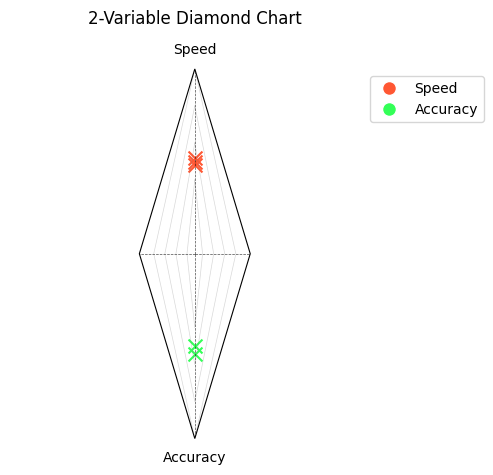

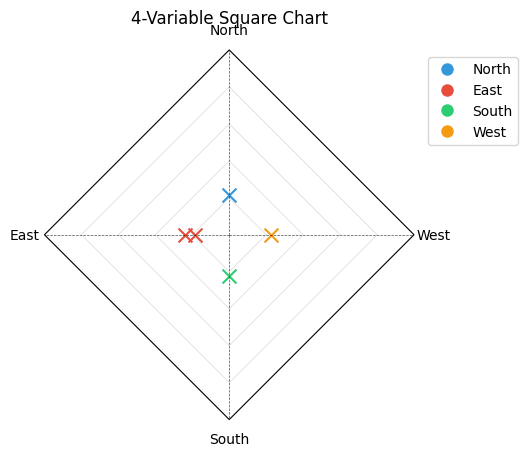

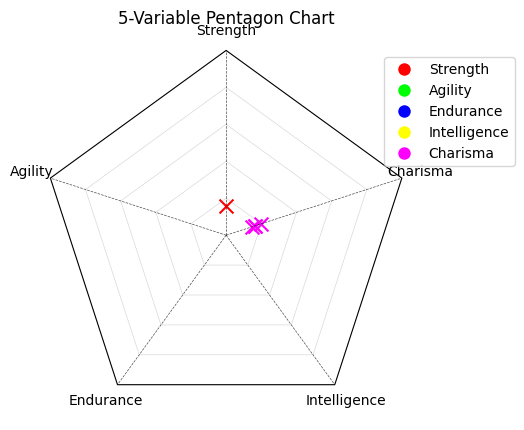

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon, Polygon, Circle
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.transforms import Affine2D
from matplotlib.spines import Spine
from matplotlib.path import Path

def radar_factory(num_vars, frame='polygon', horizontal_scale=0.3, is_diamond=False):
    theta = np.linspace(0, 2 * np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):
        name = 'radar'

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.set_theta_zero_location('N')

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            if frame == 'polygon' and is_diamond:
                # Diamond shape for 2-variable datasets expanded to 4 points
                diamond_verts = np.array([
                    [0.5, 1.0],                          # Top
                    [0.5 + 0.5*horizontal_scale, 0.5],   # Right (compressed)
                    [0.5, 0.0],                          # Bottom
                    [0.5 - 0.5*horizontal_scale, 0.5],   # Left (compressed)
                ])
                return Polygon(diamond_verts, edgecolor="k", linewidth=2, closed=True)
            elif frame == 'polygon':
                # Regular polygon for all other cases (including actual 4-variable data)
                return RegularPolygon((0.5, 0.5), num_vars, radius=0.5, edgecolor="k", linewidth=2)
            elif frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'polygon' and is_diamond:
                # Diamond spine for 2-variable datasets
                verts = np.array([
                    [0, 1],                    # Top
                    [horizontal_scale, 0],     # Right (compressed)
                    [0, -1],                   # Bottom
                    [-horizontal_scale, 0],    # Left (compressed)
                ])
                path = Path(np.vstack([verts, verts[0]]), 
                           [Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.CLOSEPOLY])
                spine = Spine(axes=self, spine_type='circle', path=path)
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5) + self.transAxes)
                return {'polar': spine}
            elif frame == 'polygon':
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5) + self.transAxes)
                return {'polar': spine}
            elif frame == 'circle':
                return super()._gen_axes_spines()
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

def create_radar_chart(categories, data, category_colors, title, horizontal_scale=0.3):
    """
    Create a radar chart with colors assigned by category.
    
    Parameters:
    - categories: list of category names
    - data: list of lists, each inner list is a dataset with values for each category
    - category_colors: list of colors for each category (must match length of categories)
    - title: chart title
    - horizontal_scale: compression factor for diamond charts
    """
    num_vars = len(categories)
    
    # Validate that colors match categories
    if len(category_colors) != num_vars:
        raise ValueError(f"Number of colors ({len(category_colors)}) must match number of categories ({num_vars})")

    # ========== 2-Class Diamond Mode ==========
    diamond_mode = False
    if num_vars == 2:
        diamond_mode = True
        # For diamond, use 4 points (top, right, bottom, left)
        theta = radar_factory(4, horizontal_scale=horizontal_scale, is_diamond=True)
        
        # Store original colors before expanding
        original_colors = category_colors.copy()
        
        # Pad categories and data for diamond format
        categories = [categories[0], '', categories[1], '']  # Blank side labels
        # Expand colors to match the 4-point format (but sides won't be used)
        category_colors = [original_colors[0], '', original_colors[1], '']
        
        padded_data = []
        for d in data:
            if len(d) != 2:
                raise ValueError("2-class data requires exactly 2 values per dataset")
            padded_data.append([d[0], 0, d[1], 0])  # Add zero-valued side points
        data = padded_data
        num_vars = 4
    else:
        theta = radar_factory(num_vars, is_diamond=False)
    # ========== End 2-Class Mode ==========

    fig, ax = plt.subplots(subplot_kw=dict(projection='radar'))

    # Normalization (modified for diamond mode)
    normalized_data = []
    for d in data:
        row_sum = sum(d)
        if not diamond_mode:
            norm_d = [val/row_sum for val in d]
        else:
            # Only top and bottom are nonzero
            norm_d = [
                d[0]/(d[0]+d[2]) if (d[0]+d[2]) != 0 else 0,  # Top
                0,                                             # Right (keep zero)
                d[2]/(d[0]+d[2]) if (d[0]+d[2]) != 0 else 0,  # Bottom
                0                                              # Left (keep zero)
            ]
        normalized_data.append(norm_d)

    # Turn off all default grid
    ax.grid(False)

    # Create custom polygonal grid lines
    grid_values = np.linspace(0.1, 1, 6)  # Adjusted grid values (proportions)
    for g in grid_values:
        if diamond_mode:
            # Draw compressed diamond grid lines
            r = [g, g*horizontal_scale, g, g*horizontal_scale, g]  # Compressed sides
            ax.plot(np.append(theta, theta[0]), r, color='gray', linestyle='-', linewidth=0.5, alpha=0.3)
        else:
            # Regular polygon grid
            polygon_vertices = []
            for t in theta:
                polygon_vertices.append((t, g))
            polygon_vertices.append((theta[0], g))  # Close the polygon correctly
            ax.plot(*zip(*polygon_vertices), color='gray', linestyle='-', linewidth=0.5, alpha=0.3)

    # Add radial lines connecting origin to each variable
    for t in theta:
        ax.plot([t, t], [0.1, 1], color='black', linestyle='--', linewidth=0.5, alpha=0.7)

    # Plot only the maximum value of each dataset
    # Now with category-based coloring
    for i, d in enumerate(normalized_data):
        max_value_index = np.argmax(d)
        
        # Use color based on category (not dataset)
        if diamond_mode:
            # In diamond mode, map back to original category
            if max_value_index == 0:
                category_color = original_colors[0]  # Top point uses first category color
            elif max_value_index == 2:
                category_color = original_colors[1]  # Bottom point uses second category color
            else:
                # This shouldn't happen as sides are always zero
                category_color = 'gray'
        else:
            # Regular mode - use the category's color directly
            category_color = category_colors[max_value_index]
        
        ax.scatter(theta[max_value_index], d[max_value_index], s=100, 
                  color=category_color, marker='x')

    ax.set_varlabels(categories)
    ax.set_ylim(0.1, 1)
    ax.set_yticks([])
    
    plt.title(title, y=1.1 if diamond_mode else 1.05)  # Adjust title position
    
    # Create a legend for categories instead of datasets
    if not diamond_mode:
        legend_elements = []
        for i, cat in enumerate(categories):
            if cat:  # Skip empty category labels (sides in diamond mode)
                legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
                                               markerfacecolor=category_colors[i], 
                                               markersize=10, label=cat))
        ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.3, 1.0))
    else:
        # Diamond mode - only show the two actual categories
        legend_elements = [
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=original_colors[0], 
                     markersize=10, label=categories[0]),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=original_colors[1], 
                     markersize=10, label=categories[2])  # Index 2 has the second category
        ]
        ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.3, 1.0))
    
    return fig, ax

if __name__ == "__main__":
    # Example: Diamond (2 variables)
    categories = ['Speed', 'Accuracy']
    data = [[88, 78],
 [64, 92],
 [57, 70],
 [88, 68],
 [72, 60]]
    category_colors = ['#FF5733', '#33FF57'] 
    create_radar_chart(categories, data, category_colors,
                       title="2-Variable Diamond Chart")

    # Example: Square (4 variables)
    categories = ['North', 'East', 'South', 'West']
    data = [[30, 23, 27, 22],
 [21, 31, 25, 21],
 [20, 31, 31, 36],
 [29, 35, 34, 34],
 [38, 31, 39, 22]]
    category_colors = ['#3498DB', '#E74C3C', '#2ECC71', '#F39C12']
    create_radar_chart(categories, data, category_colors,
                       title="4-Variable Square Chart")

    # Example: Pentagon (5 variables)
    categories = ['Strength', 'Agility', 'Endurance', 'Intelligence', 'Charisma']
    data = [[86, 56, 70, 58, 88],
 [67, 53, 74, 63, 99],
 [58, 75, 51, 69, 77],
 [96, 56, 93, 57, 96],
 [84, 63, 66, 85, 99]]
    category_colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF']
    create_radar_chart(categories, data,
                       category_colors,
                       title="5-Variable Pentagon Chart")

    plt.show()


In [46]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon, Polygon, Circle
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.transforms import Affine2D
from matplotlib.spines import Spine
from matplotlib.path import Path

def radar_factory(num_vars, frame='polygon', horizontal_scale=0.3, is_diamond=False):
    theta = np.linspace(0, 2 * np.pi, num_vars, endpoint=False)
    class RadarAxes(PolarAxes):
        name = 'radar'
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.set_theta_zero_location('N')
        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)
        def _gen_axes_patch(self):
            if frame == 'polygon' and is_diamond:
                diamond_verts = np.array([
                    [0.5, 1.0],
                    [0.5 + 0.5*horizontal_scale, 0.5],
                    [0.5, 0.0],
                    [0.5 - 0.5*horizontal_scale, 0.5],
                ])
                return Polygon(diamond_verts, edgecolor="k", linewidth=2, closed=True)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars, radius=0.5, edgecolor="k", linewidth=2)
            elif frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)
        def _gen_axes_spines(self):
            if frame == 'polygon' and is_diamond:
                verts = np.array([
                    [0, 1],
                    [horizontal_scale, 0],
                    [0, -1],
                    [-horizontal_scale, 0],
                ])
                path = Path(np.vstack([verts, verts[0]]),
                           [Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.CLOSEPOLY])
                spine = Spine(axes=self, spine_type='circle', path=path)
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5) + self.transAxes)
                return {'polar': spine}
            elif frame == 'polygon':
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5) + self.transAxes)
                return {'polar': spine}
            elif frame == 'circle':
                return super()._gen_axes_spines()
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)
    register_projection(RadarAxes)
    return theta

def create_radar_chart(categories, data, category_colors, title, horizontal_scale=0.3, ax=None):
    num_vars = len(categories)
    if len(category_colors) != num_vars:
        raise ValueError(f"Number of colors ({len(category_colors)}) must match number of categories ({num_vars})")
    diamond_mode = False
    if num_vars == 2:
        diamond_mode = True
        theta = radar_factory(4, horizontal_scale=horizontal_scale, is_diamond=True)
        original_colors = category_colors.copy()
        categories = [categories[0], '', categories[1], '']
        category_colors = [original_colors[0], '', original_colors[1], '']
        padded_data = []
        for d in data:
            if len(d) != 2:
                raise ValueError("2-class data requires exactly 2 values per dataset")
            padded_data.append([d[0], 0, d[1], 0])
        data = padded_data
        num_vars = 4
    else:
        theta = radar_factory(num_vars, is_diamond=False)
    if ax is None:
        fig, ax = plt.subplots(subplot_kw=dict(projection='radar'))
    else:
        fig = ax.figure
    normalized_data = []
    for d in data:
        row_sum = sum(d)
        if not diamond_mode:
            norm_d = [val/row_sum for val in d]
        else:
            norm_d = [
                d[0]/(d[0]+d[2]) if (d[0]+d[2]) != 0 else 0,
                0,
                d[2]/(d[0]+d[2]) if (d[0]+d[2]) != 0 else 0,
                0
            ]
        normalized_data.append(norm_d)
    ax.grid(False)
    grid_values = np.linspace(0.1, 1, 6)
    for g in grid_values:
        if diamond_mode:
            r = [g, g*horizontal_scale, g, g*horizontal_scale, g]
            ax.plot(np.append(theta, theta[0]), r, color='gray', linestyle='-', linewidth=0.5, alpha=0.3)
        else:
            polygon_vertices = []
            for t in theta:
                polygon_vertices.append((t, g))
            polygon_vertices.append((theta[0], g))
            ax.plot(*zip(*polygon_vertices), color='gray', linestyle='-', linewidth=0.5, alpha=0.3)
    for t in theta:
        ax.plot([t, t], [0.1, 1], color='black', linestyle='--', linewidth=0.5, alpha=0.7)
    for i, d in enumerate(normalized_data):
        max_value_index = np.argmax(d)
        if diamond_mode:
            if max_value_index == 0:
                category_color = original_colors[0]
            elif max_value_index == 2:
                category_color = original_colors[1]
            else:
                category_color = 'gray'
        else:
            category_color = category_colors[max_value_index]
        ax.scatter(theta[max_value_index], d[max_value_index], s=100, color=category_color, marker='x')
    ax.set_varlabels(categories)
    ax.set_ylim(0.1, 1)
    ax.set_yticks([])
    ax.set_title(title, y=1.1 if diamond_mode else 1.05)
    # if not diamond_mode:
    #     legend_elements = []
    #     for i, cat in enumerate(categories):
    #         if cat:
    #             legend_elements.append(plt.Line2D([0], [0], marker='o', color='w',
    #                                               markerfacecolor=category_colors[i],
    #                                               markersize=10, label=cat))
    #     ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.3, 1.0))
    # else:
    #     legend_elements = [
    #         plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=original_colors[0],
    #                    markersize=10, label=categories[0]),
    #         plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=original_colors[1],
    #                    markersize=10, label=categories[2])
    #     ]
    #     ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.3, 1.0))
    return fig, ax

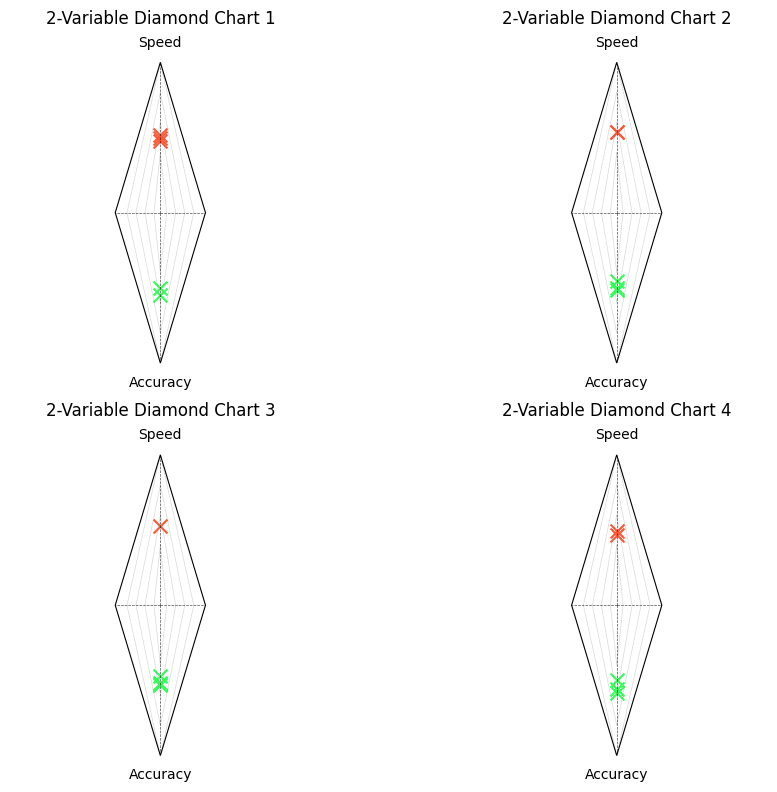

In [48]:
if __name__ == "__main__":
    fig = plt.figure(figsize=(10, 8))
    axs = [
        fig.add_subplot(2, 2, 1, projection='radar'),
        fig.add_subplot(2, 2, 2, projection='radar'),
        fig.add_subplot(2, 2, 3, projection='radar'),
        fig.add_subplot(2, 2, 4, projection='radar')
    ]

    categories = ['Speed', 'Accuracy']
    colors = ['#FF5733', '#33FF57']

    # Four different 2-class datasets
    data_sets = [
        [[88, 78], [64, 92], [57, 70], [88, 68], [72, 60]],
        [[60, 73], [85, 89], [73, 52], [71, 51], [73, 93]],
        [[79, 87], [51, 70], [82, 61], [71, 93], [74, 98]],
        [[76, 91], [77, 65], [64, 96], [100, 93], [52, 86]]
    ]

    for i in range(4):
        create_radar_chart(categories, data_sets[i], colors, f"2-Variable Diamond Chart {i+1}", ax=axs[i])

    plt.tight_layout()
    plt.show()